# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from icecream import ic

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int32(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    Ig_copy = np.zeros_like(Ig)
    for i in range(1, n-1):
        for j in range(1, m-1):
            if Ior[i,j] == 1:
                local = Ig[i,j-1:j+2]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 2:
                local = np.array([Ig[i-1,j-1], Ig[i, j], Ig[i+1, j+1]])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 3:
                local = Ig[i-1:i+2, j]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 4:
                local = np.array([Ig[i+1,j-1], Ig[i, j], Ig[i-1, j+1]])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
    return Ig_copy

h_sobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # Directionnal derivate 
    I_x = convolve2d(image, h_sobel, boundary='symm') # avec padding copy
    I_y = convolve2d(image, h_sobel.T, boundary='symm')

    # Computation of the product
    I_x2 = I_x**2
    I_y2 = I_y**2
    I_xI_y = I_x*I_y

    # Convolution w/ gaussianKernel
    N = (1/3) * (int(0.5*(scale-1)))
    w = gaussianKernel(N)
    I_x2 = convolve2d(I_x2, w, mode='same') # Sans padding 
    I_y2 = convolve2d(I_y2, w, mode='same')
    I_xI_y = convolve2d(I_xI_y, w, mode="same")
    
    # Computation of det and return
    M = np.array([[I_x2, I_xI_y], [I_xI_y, I_y2]])
    det = M[0,0]*M[1,1] - M[1,0]*M[0,1]
    return det - kappa * np.trace(M)**2

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

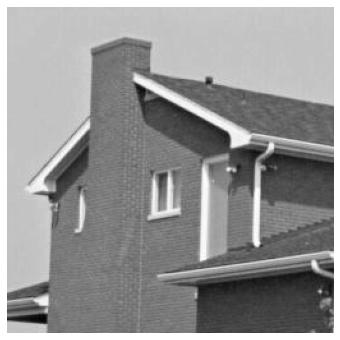

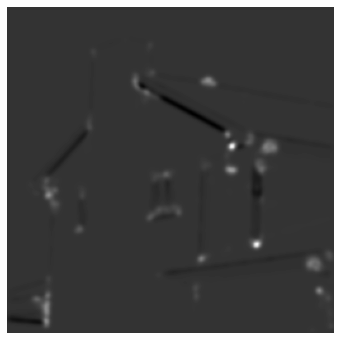

In [3]:
def to_disp_harris_R(R):
    R_copy = R.copy()
    return np.where(R_copy>0, 1, 0)
house = np.array(Image.open('./img/house2.png'))
harris_house = computeR(house, 15, 0.04)
imshow(house)
imshow(harris_house)
# imshow(to_disp_harris_R(harris_house), "avec le critère de positivité")

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

**En utilisant une bonne technique de padding, on évite les problèmes dans les coins**

**On a vu en TD qu'on pouvait écrire $E(u,v)$ comme $(u,v) M (u,v)^T$. Quand $E(u,v)$ est grand, il y a changement dans plusieurs directions, quand il est petit, dans pas de direction.**

**Pour trouver le nombre de direction, on utilises les valeurs propres de $M$ et la formule de $R = \det M - k trace(M)^2 = \lambda_1\lambda_2 - k (\lambda_1 + \lambda_2)^2$.**

**On peut alors refaire le raisonnement fait en TD :**
- **When |R| is small, which happens when λ1 and λ2 are small, the region is flat.**
- **When R<0, which happens when λ1>>λ2 or vice versa, the region is an edge.**
- **When R is large, which happens when λ1 and λ2 are large and λ1∼λ2, the region is a corner.**

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [4]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R>=thres, 1, 0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [5]:
def rnms(R, R_bin):
    """ Array[n, m] -> Array[n, m] 
    """
    n, m = R.shape
    R_copy = np.zeros_like(R)
    for i in range(1, n-1):
        for j in range(1, m-1):
            neighborhood = R[i-1:i+2, j-1:j+2]
            neigh_max = np.max(neighborhood)
            # ic(neighborhood)
            # ic(neigh_max)
            # count_max = np.where(neighborhood==neigh_max, 1, 0).sum()
            # ic(count_max)
            if R[i,j] == neigh_max and R_bin[i,j] == 1: # and count_max == 1:
                R_copy[i,j] = 1
    return R_copy

**'un algo avec `np.roll` :o**

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [6]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    R = rnms(R, thresholdR(R, thres*R.max()))
    return R

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

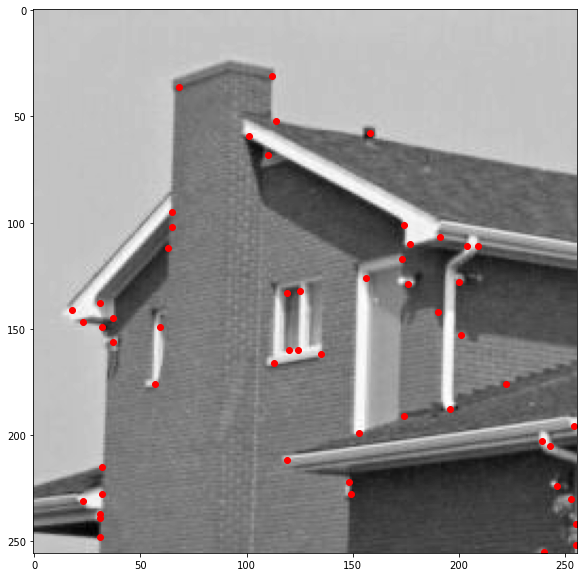

In [7]:
def display_corner(img, scale, kappa, thresh, ax=None):
    Cmap = cornerDetector(img, scale, kappa, thresh)
    if not ax:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.scatter(*np.nonzero(Cmap.T), c='red')

display_corner(house, 15 , 0.04, 0.01)

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

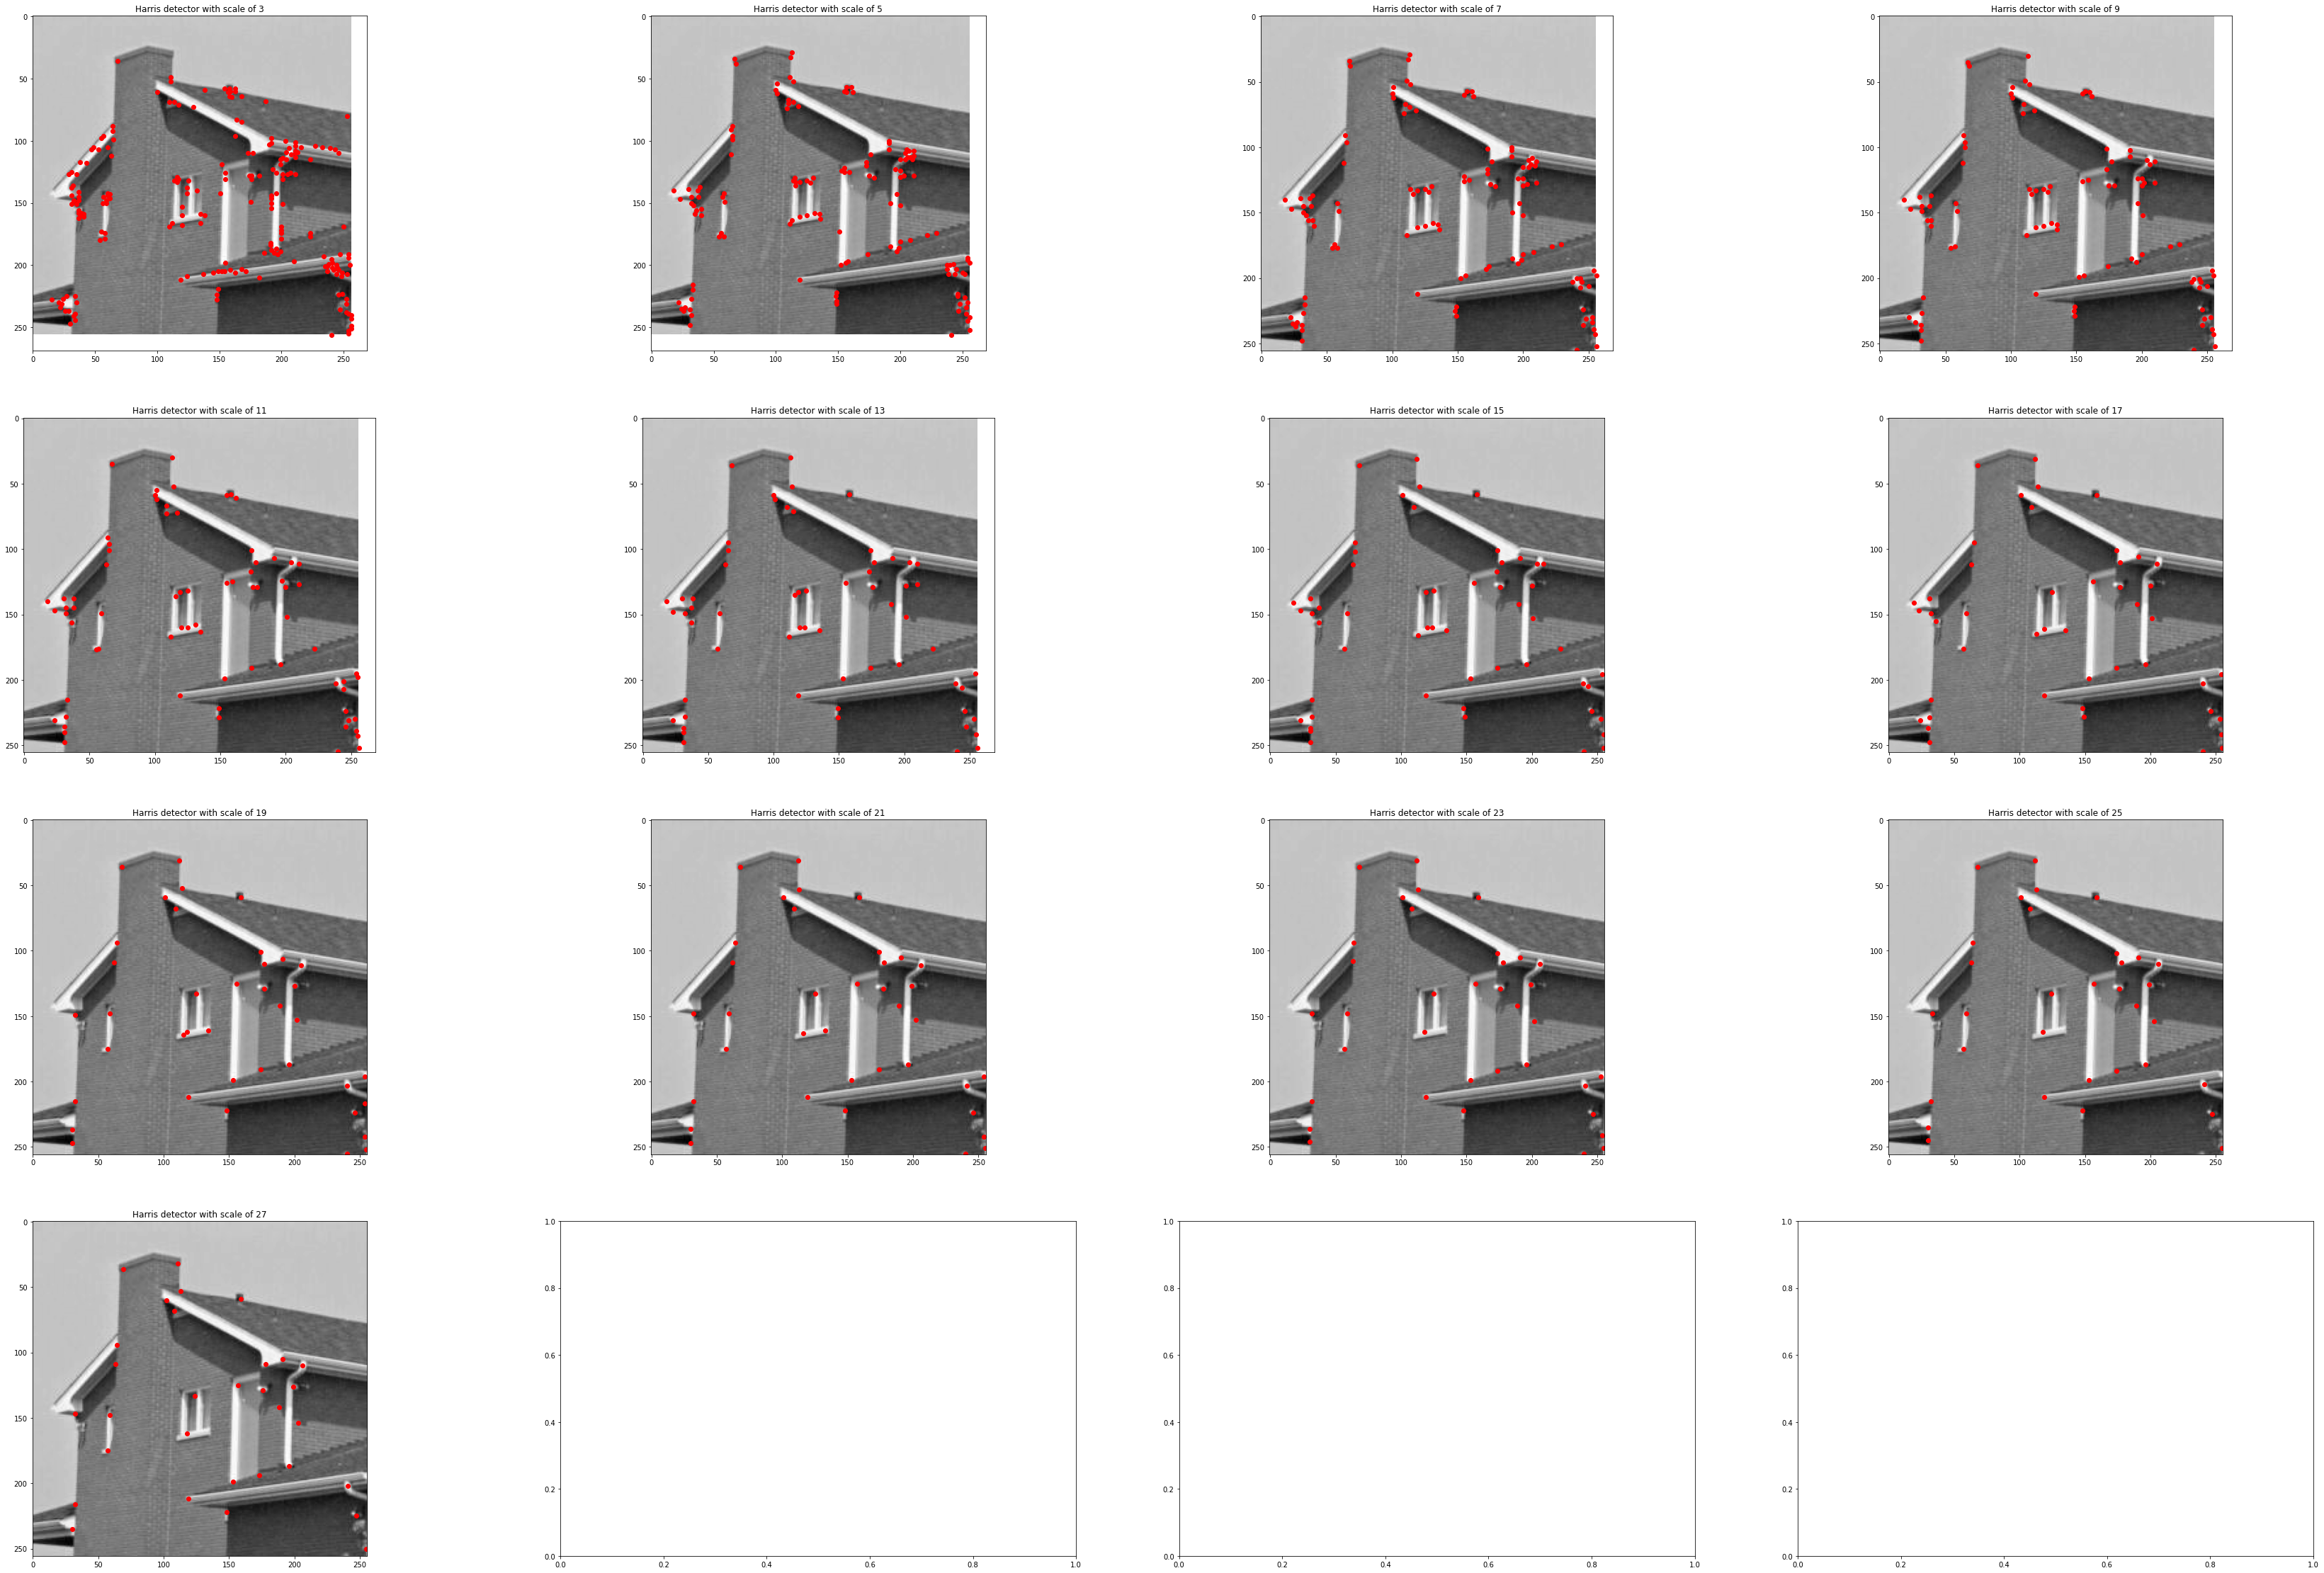

In [8]:
scale_list = list(range(3, 29, 2))
n = int(len(scale_list)/4) + 1
fig, ax = plt.subplots(nrows=n, ncols=4, figsize = (6*10,4*10))
ax = ax.flatten()
for i in range(len(scale_list)):
    display_corner(house, scale_list[i] , 0.04, 0.01, ax[i])
    ax[i].set_title(f"Harris detector with scale of {scale_list[i]}")

**Augmenter la scale semble être assez bénéfique au filtre avec une threshold à $0.01 \max R$. En théorie, on lisse $R$ de plus en plus fort, éliminant ainsi le bruit mais perdant en précision spacial mais ça a l'air d'aller ici.**

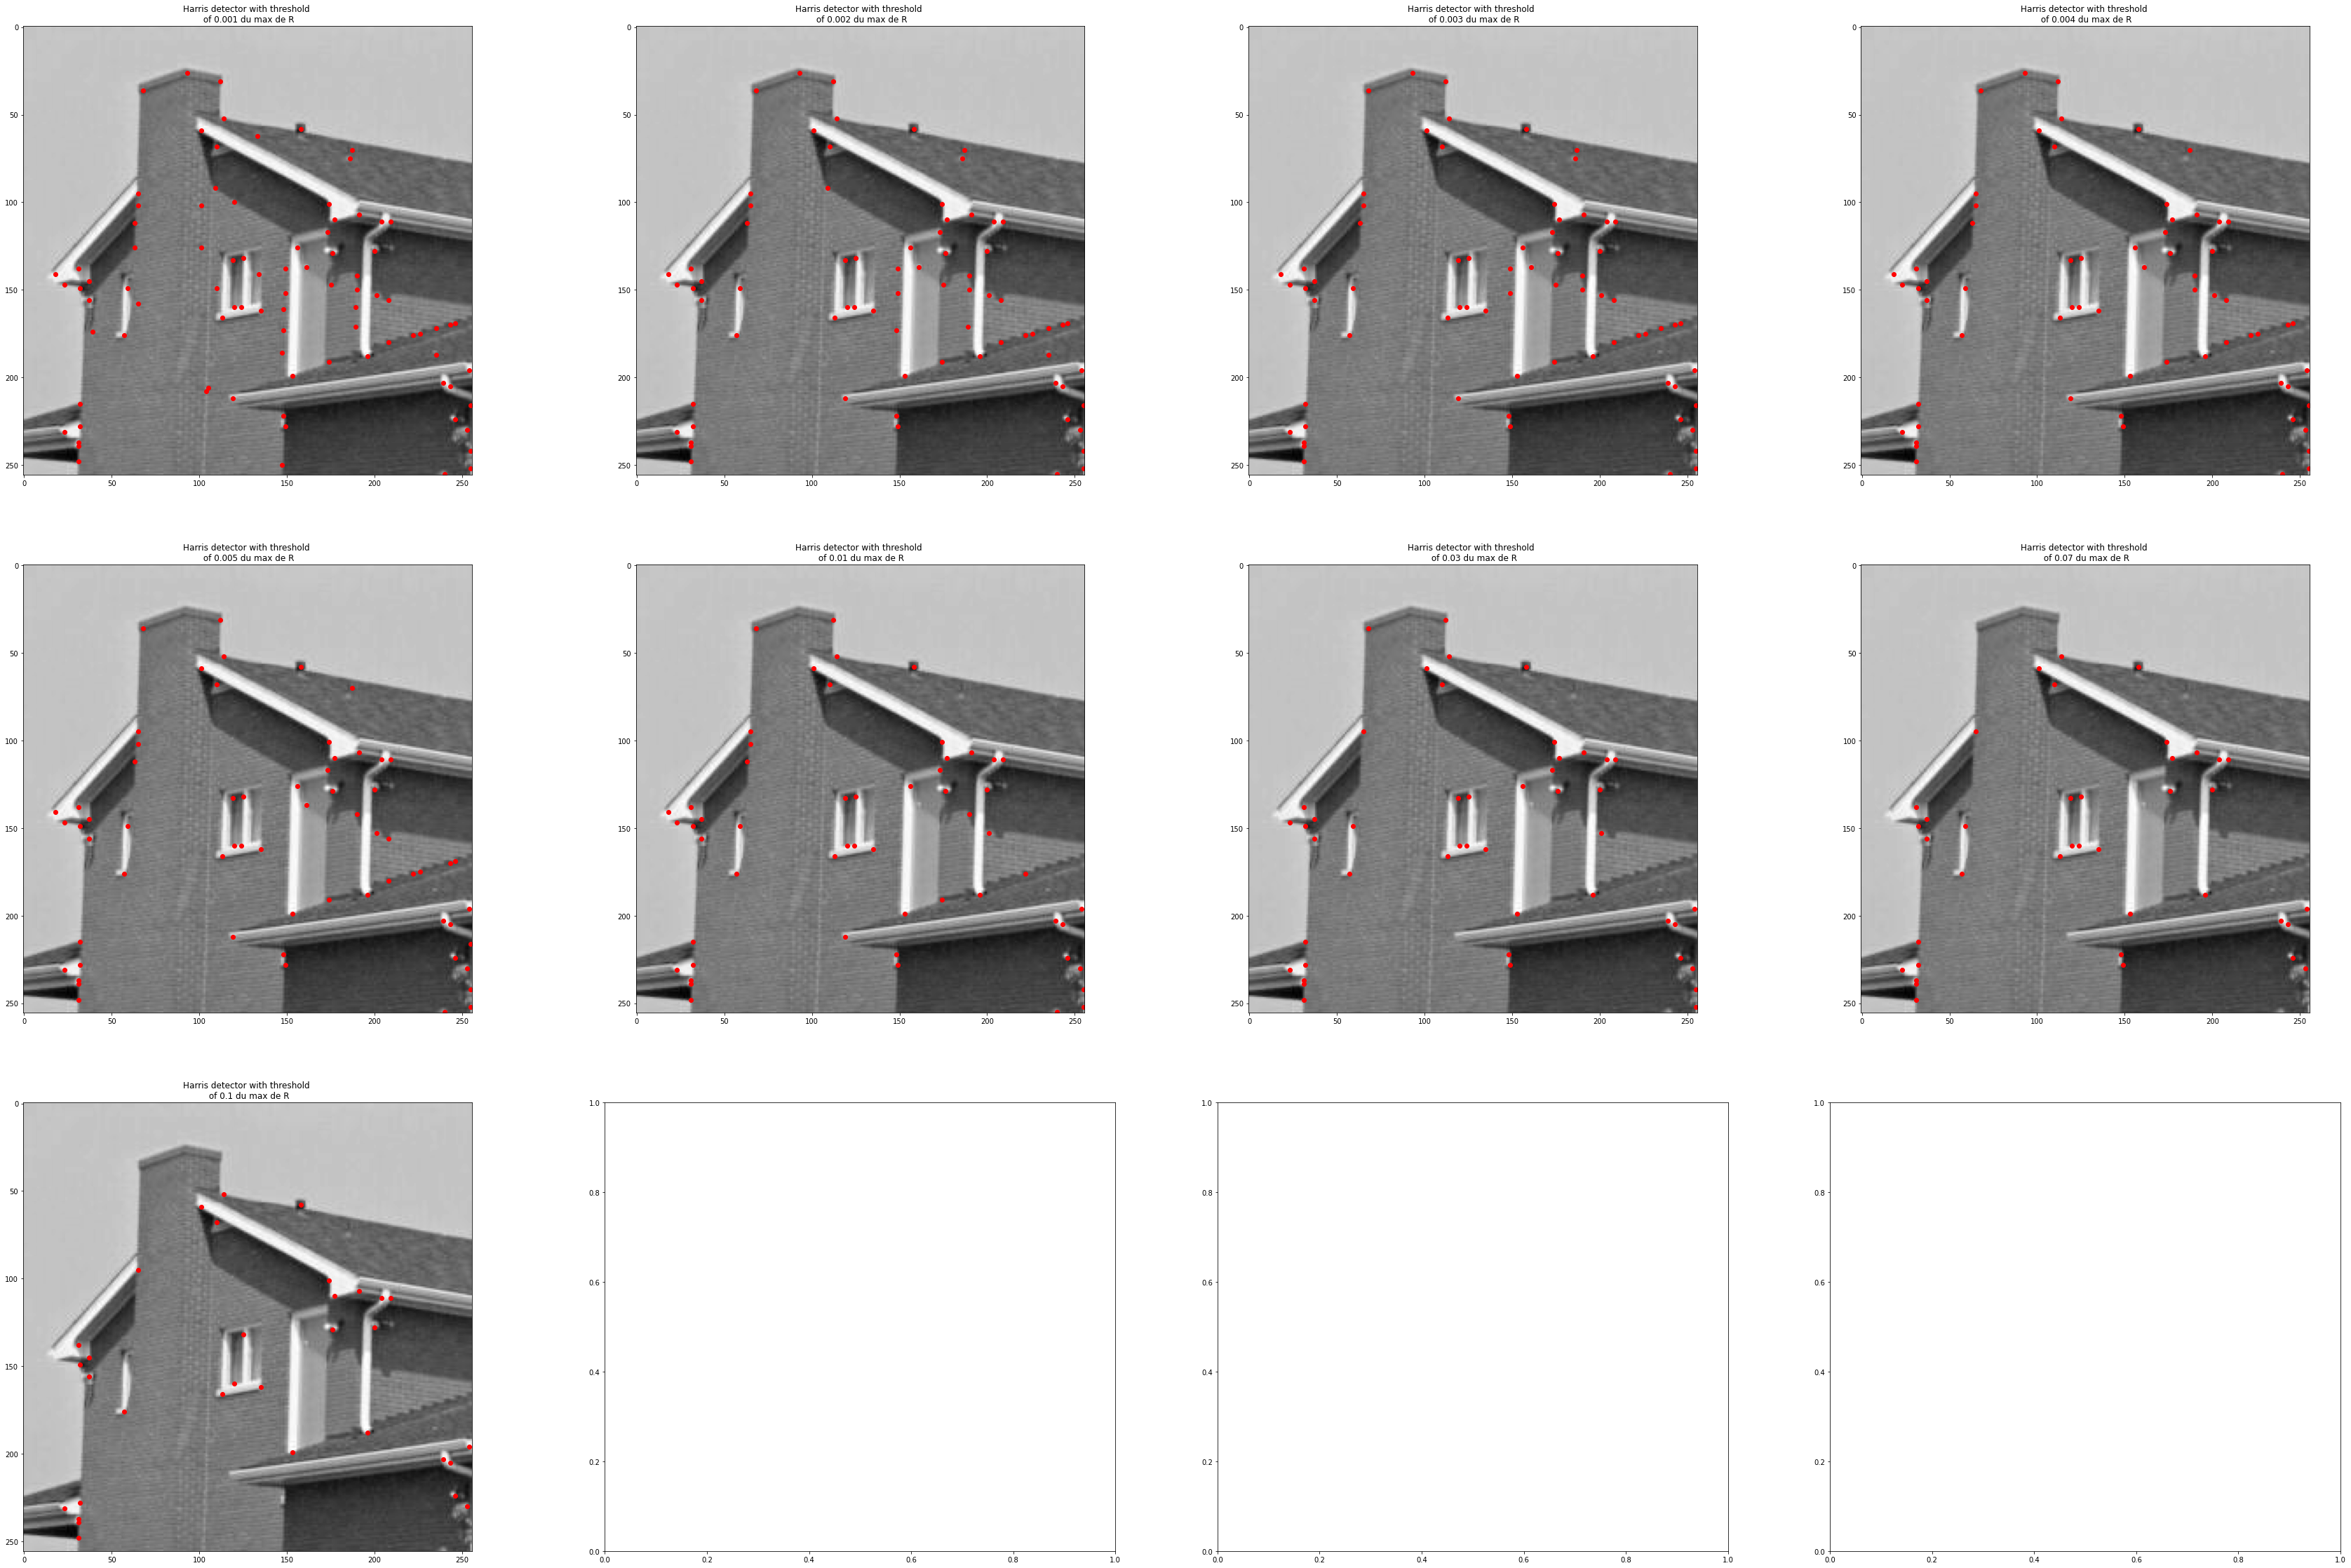

In [9]:
thres_list = [0.001,0.002, 0.003, 0.004, 0.005, 0.01, 0.03, 0.07, 0.1]
n = int(len(thres_list)/4) + 1
fig, ax = plt.subplots(nrows=n, ncols=4, figsize = (6*10,4*10))
ax = ax.flatten()
for i in range(len(thres_list)):
    display_corner(house, 15 , 0.04, thres_list[i], ax[i])
    ax[i].set_title(f"Harris detector with threshold \n of {round(thres_list[i], 4)} du max de R")

**Changer la threshold fait également disparaître du bruit (première image sur la texture des briques), il semble assez sensible.**

**Je préfère quand même jouer sur le filtre gaussien**

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

In [10]:
toy1 = np.array(Image.open("./img/toyHorse1.png"))
toy2 = np.array(Image.open("./img/toyHorse2.png"))

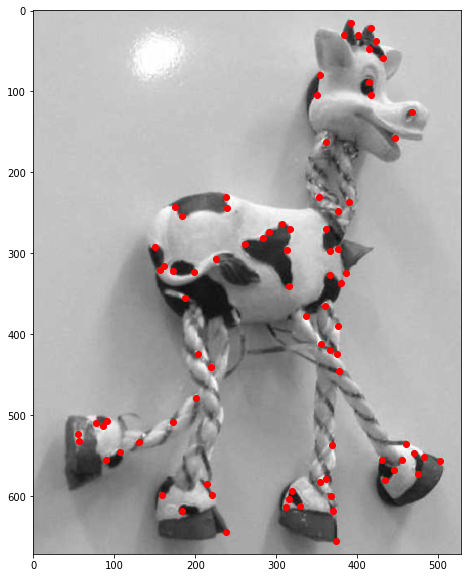

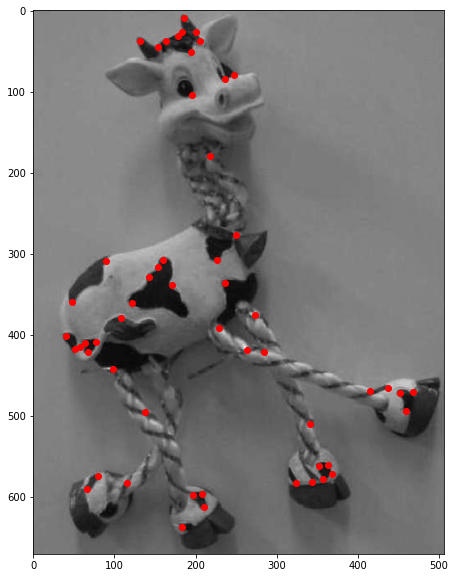

In [11]:
display_corner(toy1, 24, 0.04, 0.07)
display_corner(toy2, 24, 0.04, 0.07)

2) What are the dynamic ranges of these two images ?

In [12]:
def countPixels(I,k):
    """ Array*int -> int"""
    return len(np.where(I==k)[0])

def computeHistogram(I):
    """ Array -> list[int] """
    l = []
    for i in range(257):
        l.append(countPixels(I, i)) # Absolument pas optimisé car on parcours l'image à chaque fois
                                    # On pourrait sinon faire une boucle unique avec un dictionnaire i:nb_i
    return np.array(l)

def plot_histogram(img):
    y = computeHistogram(img)
    x = list(range(len(y)))
    w = [1]*len(y)
    fig, ax = plt.subplots()
    plt.bar(x,y, w, align='center')
    plt.show()

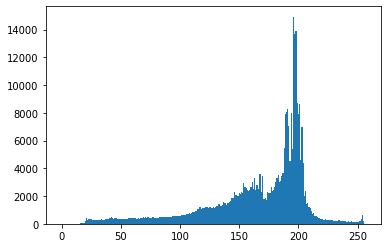

(1, 255)

In [13]:
plot_histogram(toy1)
toy1.min(), toy1.max()

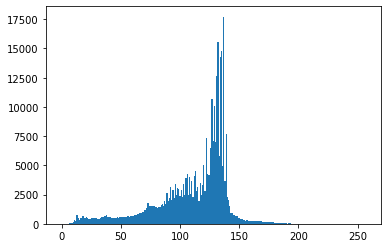

(0, 253)

In [14]:
plot_histogram(toy2)
toy2.min(), toy2.max()

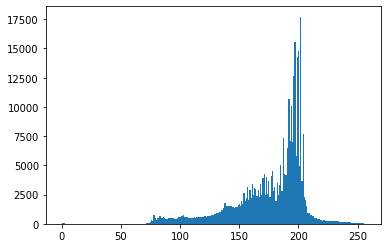

(0, 253)

In [15]:
plot_histogram(toy2+65)
toy2.min(), toy2.max()

**They're both encoded on 8 bit which mean $2^8 = 256$ values. The second image got a max of 253 which is a little less than the first. Nevertheless, the brightness of both image is clearly different. We can see that with on the histogram too.**

3) What are the transformations beetween the two images ?

**En plus du changement de brightness, il y a globalement eu une rotation et un changement d'angle de vue.**

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

**Dans la question 1, on arrive déjà à detecter certain point en commun. Notamment en passant la scale de 15 à 24. Mais dans ce cas, la threshold était dynamique. Essayons avec une threshold fixe valant la moyenne des deux threshold dynamique**

In [16]:
R = computeR(toy1, 15, 0.04)
R2 = computeR(toy2, 15, 0.04)
thres = (R.max() + R2.max())/2
thres = 0.07*thres
ic(R.max())
ic(R2.max())
ic(thres)

ic| R.max(): 2900503106.8822985
ic| R2.max(): 1244983054.429096
ic| thres: 145092015.64589882


145092015.64589882

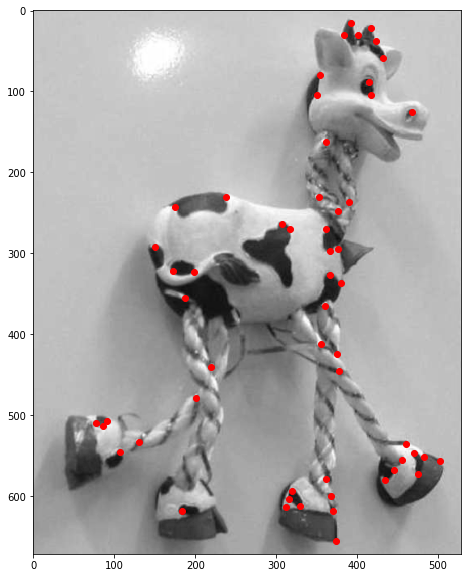

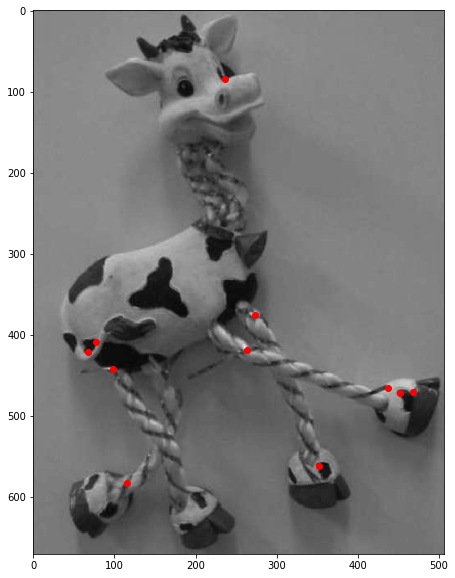

In [17]:
def cornerDetector_fixed_thresh(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    R = rnms(R, thresholdR(R, thres))
    return R

def display_corner_fixed_thresh(img, scale, kappa, thresh):
    Cmap = cornerDetector_fixed_thresh(img, scale, kappa, thresh)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.scatter(*np.nonzero(Cmap.T), c='red')

display_corner_fixed_thresh(toy1, 24 , 0.04, thres)
display_corner_fixed_thresh(toy2, 24 , 0.04, thres)

**Utiliser une threshold fixe ne fonctionne pas du tout, c'est peut être du au changement de luminosité. Le maximum de $R$ n'est pas du tout le même.**

**Testons avec la même luminosité**

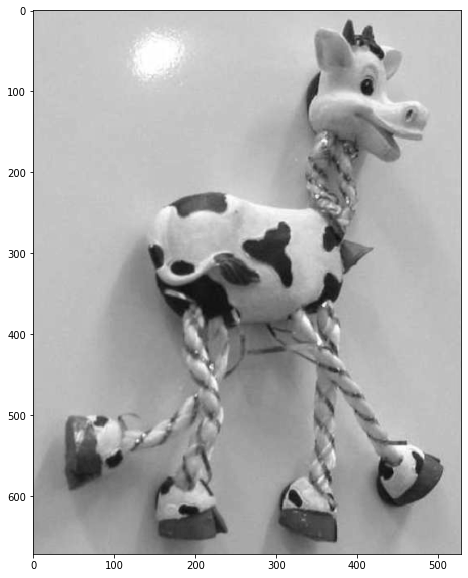

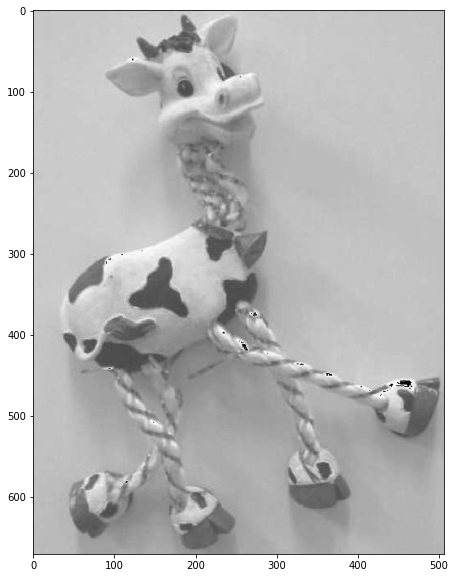

In [18]:
display_corner(toy1, 24 , 0.04, thres)
display_corner((toy2+65).clip(max=255), 24 , 0.04, thres)

**Ca n'a pas l'air de fix le problème**

**CCL : Sans modifier la threshold, le detecteur de coin d'Harris ne semble pas être très résilien au transformation. En revanche, comme on peut le voir sur la première question, avec une threshold dynamique en fonction du $\max R$, ça se passe bien.**